In [1]:
using Distributed
using SharedArrays
addprocs(11);

In [2]:
@everywhere include("inverse_prob.jl")

In [3]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;
x = range(0,step=h,length=Nx)
y = range(0,step=h,length=Ny)
    
Fs = 400;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
source_position = zeros(11,2)
for i = 1:11
    source_position[i,:] = [5 10*(i-1)+1]
#     source_position[i,:] = [5 51]
end
source = repeat(source, 1, 11)

receiver_position = zeros(51,2)
for i = 1:51
    receiver_position[i,:] = [1, (i-1)*2+1]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)
# c[50:end,:] .= 1.1
# c[30:40,30:60] .= 1.05
# c[60:80,60:80] .= 1.15
# c[30:50,20:40] .= 1.05
# c = imfilter(c, Kernel.gaussian(10));
    
c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
# c0[50:70,60:80] .= 1.05
for i = 1:Nx
    for j = 1:Ny
        if sqrt((x[i]-0.5).^2 + (y[j]-0.5).^2) < 0.2
            c0[i,j] = 1.05
        end
    end
end
            
c = imfilter(c0, Kernel.gaussian(20));

cc = ones(Nx, Ny)
rhoc = ones(Nx, Ny)

pml_len = 20
pml_coef = 50
end

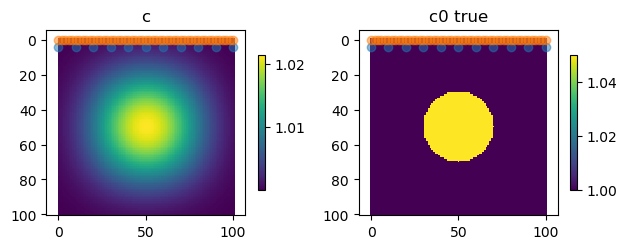

In [4]:
figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0 true")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)

tight_layout()

In [5]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time datac, uc = multi_solver_parallel(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
# u0=[]
uc=[]

 16.972250 seconds (7.68 M allocations: 384.831 MiB, 1.04% gc time)
  4.544199 seconds (5.74 k allocations: 250.703 KiB)
  4.545006 seconds (5.65 k allocations: 247.078 KiB)


0-element Array{Any,1}

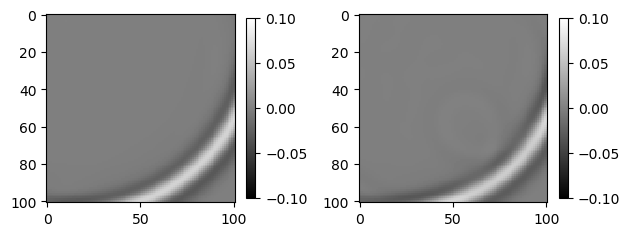

In [6]:
figure;
subplot(121); imshow(u[:,:,500,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122); imshow(u0[:,:,500,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

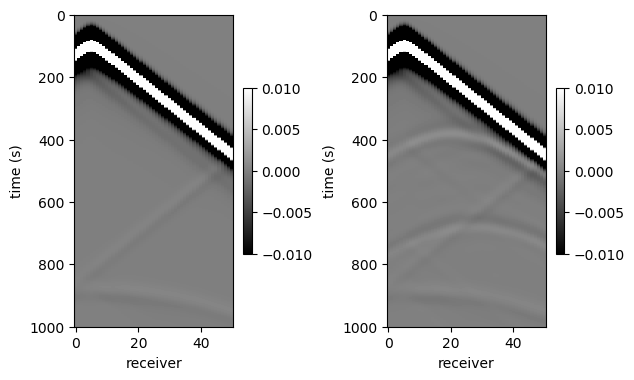

In [7]:
figure;
r_axis = 0:21
subplot(121); imshow(data[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

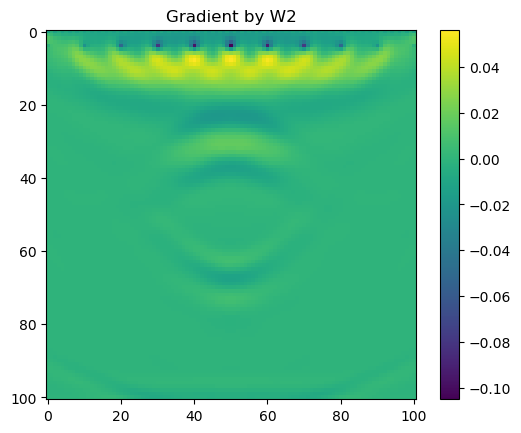

 27.369863 seconds (11.28 M allocations: 8.930 GiB, 3.40% gc time)


PyObject Text(0.5, 1, 'Gradient by W2')

In [8]:
@time gg, dd = grad_sinkhorn_parallel(data-datac, u, data0-datac, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position;reg_p=0, pml_len=10, pml_coef=100, reg=5e-3, reg_m=1e2, iterMax=50, verbose=false);
imshow(gg); colorbar(); title("Gradient by W2")

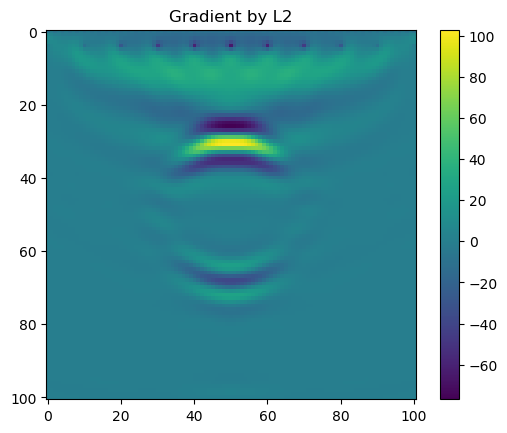

 27.833523 seconds (9.94 M allocations: 123.916 GiB, 19.80% gc time)


PyObject Text(0.5, 1, 'Gradient by L2')

In [9]:
@time ggl = grad_l2_parallel(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
imshow(ggl); colorbar(); title("Gradient by L2")

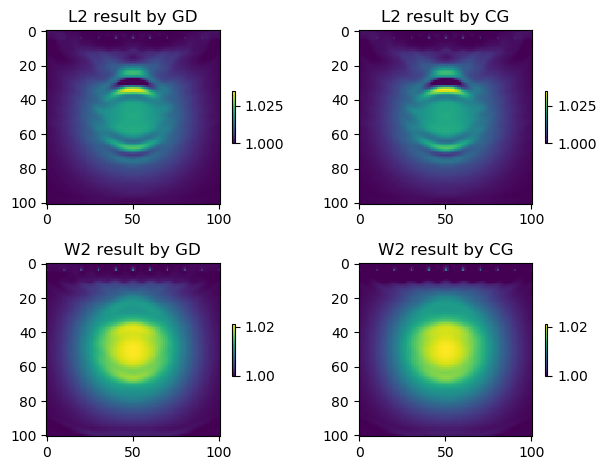

In [10]:
vars_l2_gd = matread("FWI_1_l2_gd.mat");
vars_l2_cg = matread("FWI_1_l2_cg.mat");
vars_w2_gd = matread("FWI_1_w2_gd.mat");
vars_w2_cg = matread("FWI_1_w2_cg.mat");
xl_gd = get(vars_l2_gd, "xx", 1)
xl_cg = get(vars_l2_cg, "xx", 1)
xw_gd = get(vars_w2_gd, "xx", 1)
xw_cg = get(vars_w2_cg, "xx", 1)

subplot(221)
imshow(reshape(xl_gd,101,101));colorbar(shrink=0.3); title("L2 result by GD")
subplot(222)
imshow(reshape(xl_cg,101,101));colorbar(shrink=0.3); title("L2 result by CG")
subplot(223)
imshow(reshape(xw_gd,101,101));colorbar(shrink=0.3); title("W2 result by GD")
subplot(224)
imshow(reshape(xw_cg,101,101));colorbar(shrink=0.3); title("W2 result by CG")

tight_layout()

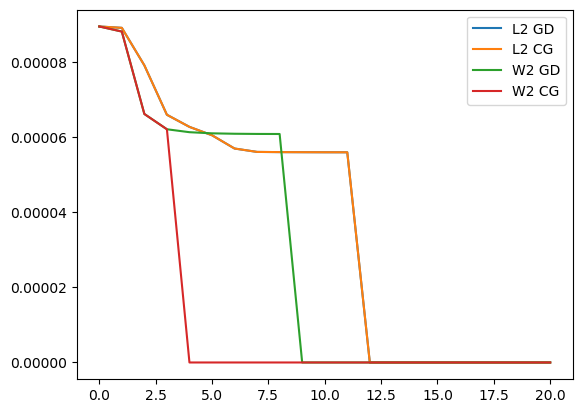

PyObject <matplotlib.legend.Legend object at 0x7f043f8632b0>

In [11]:
plot(get(vars_l2_gd, "ff", 1))
plot(get(vars_l2_cg, "ff", 1))
plot(get(vars_w2_gd, "ff", 1))
plot(get(vars_w2_cg, "ff", 1))

legend(["L2 GD", "L2 CG", "W2 GD", "W2 CG"])